In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

In [3]:
# Load data
with np.load('cifar4-train.npz', allow_pickle=False) as data:
    X = data['overfeat']
    y = data['labels']
    
print(X.shape)
print(y.shape)

(5000, 4096)
(5000,)


In [4]:
# split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, 
                                                    stratify=y, test_size=0.2)

# split train set into smaller train and validation sets:

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=0, 
                                            stratify=y_train, test_size=800)


In [5]:
# As we saw in data exploration, 392 features explain 95% of the variance

from sklearn.decomposition import PCA
pca = PCA(n_components=392)

# Decision Tree

In [6]:
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# Defining the Classifier
tree = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=0)

#creating the Pipeline with no PCA
pipe = Pipeline([
    ('pca', None),
    ('tree', tree)
])

# lets try without pca and max_depth=None first
pipe.fit(X_tr, y_tr)
full_depth_tr = pipe.score(X_tr, y_tr)
full_depth_val = pipe.score(X_val, y_val)

print('For max_depth=None we got a train accuracy of {:.3f} '
      'and validation accuracy of {:.3f}'.format(full_depth_tr, full_depth_val))

For max_depth=None we got a train accuracy of 1.000 and validation accuracy of 0.559


In [7]:
# lets try depths 1-10 and with/without pca

grid = ParameterGrid({
    'pca': [None, pca],
    'tree__max_depth': np.arange(1,11),
})

train_scores = []
val_scores = []

# doing the grid search
for params_dict in grid:
    
    pipe.set_params(**params_dict)
            
    pipe.fit(X_tr, y_tr)
          
    train_score = pipe.score(X_tr, y_tr)
    val_score = pipe.score(X_val, y_val)
    
    train_scores.append(train_score)
    val_scores.append(val_score)

In [8]:
# putting the first 10 accuraacy scores in a new list
no_pca_train_acc = train_scores[0:10]
no_pca_val_acc = val_scores[0:10]

pca_train_acc = train_scores[10:20]
pca_val_acc = val_scores[10:20]

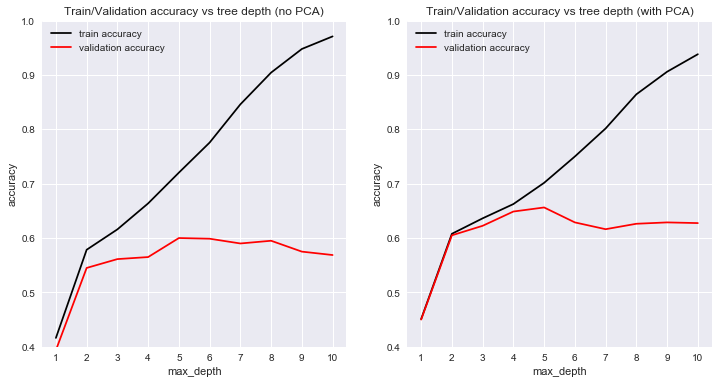

In [9]:
sns.set(rc={'figure.figsize':(12,6)})
plt.subplot(1,2,1)
plt.plot(np.arange(1,11), no_pca_train_acc, label='train accuracy', color='k')
plt.plot(np.arange(1,11), no_pca_val_acc, label='validation accuracy', color='r')
plt.title('Train/Validation accuracy vs tree depth (no PCA)')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(np.arange(1,11))
plt.ylim(0.4, 1.0)
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(1,11), pca_train_acc, label='train accuracy', color='k')
plt.plot(np.arange(1,11), pca_val_acc, label='validation accuracy', color='r')
plt.title('Train/Validation accuracy vs tree depth (with PCA)')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(np.arange(1,11))
plt.ylim(0.4, 1.0)
plt.legend()
plt.show()

In [10]:
# it seems that using PCA gives better validation accuracy for all
# values of depth.

best_val_score = np.max(pca_val_acc)
best_depth = np.argmax(pca_val_acc) + 1  # indices start from 0

print('Top accuracy on validation set with PCA: {:.3f} with depth {:.0f}'.format(best_val_score, best_depth))

Top accuracy on validation set with PCA: 0.656 with depth 5


# Random forests

In [11]:
# For computational efficiency, and since PCA obviously gave better validation
# accuracy for the decision tree, we will use it as a preprocessing step for
# random forests:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=0, max_depth=None)

pipe2 = Pipeline([
    ('pca', pca),
    ('forest', forest)
])

grid2 = ParameterGrid({
    'forest__n_estimators': [50, 100, 150, 200, 250, 300, 350, 400]
})

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [12]:
val_scores = []

for params_dict in grid2: # grid search
    
    pipe2.set_params(**params_dict)
    pipe2.fit(X_tr, y_tr)
    
    params_dict['val_acc'] = pipe2.score(X_val, y_val)
    val_scores.append(params_dict)
    
scores_df = pd.DataFrame(val_scores)
scores_df.sort_values(by='val_acc', ascending=False).head(6)

,forest__n_estimators,val_acc
7,400,0.75750
4,250,0.74875
3,200,0.74500
5,300,0.74250
6,350,0.74000
2,150,0.73875


# test accuracy on fine-tuned models:

In [13]:
# Decision Tree (with PCA and max_depth = 4)
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=0)

pipe = Pipeline([
    ('pca', pca),
    ('tree', tree)
])

pipe.fit(X_train, y_train)
tree_test_acc = pipe.score(X_test, y_test)

# Random Forest (300 estimators)
forest = RandomForestClassifier(max_depth=None, n_estimators=250, random_state=0)

pipe2 = Pipeline([
    ('pca', pca),
    ('forest', forest)
])

pipe2.fit(X_train, y_train)
forest_test_acc = pipe2.score(X_test, y_test)

In [14]:
print('Decision tree accuracy (test set): {:.3f}'.format(tree_test_acc))
print('Random forest accuracy (test set): {:.3f}'.format(forest_test_acc))

Decision tree accuracy (test set): 0.630
Random forest accuracy (test set): 0.763
